In [434]:
import pandas as pd
import regex as re
import inspect
import numpy as np
import string
import matplotlib.pyplot as plt
from gensim import corpora, models, similarities, matutils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy

In [435]:
df = pd.read_csv('transcript_df.csv')
df

,date,section,content
0,2021-07-21,Prepared remarks,Texas Instruments Incorporated (NASDAQ:TXN) Q2...
1,2021-07-21,Q&A,Session\nOperator\nThank you. [Operator Instr...
2,2021-06-02,Prepared remarks,Texas Instruments Incorporated (NASDAQ:TXN) Be...
3,2021-06-02,Q&A,Session\nQ - \n
4,2021-04-27,Prepared remarks,Texas Instruments Incorporated. (NASDAQ:TXN) Q...
...,...,...,...
147,2010-10-26,Q&A,Session\nOperator\n[Operator Instructions] Ou...
148,2010-07-20,Prepared remarks,Texas Instruments Incorporated (NASDAQ:TXN) Q2...
149,2010-07-20,Q&A,Session\nOperator\nThank you. (Operator instr...
150,2010-04-27,Prepared remarks,Texas Instruments Incorporated (NASDAQ:TXN) Q1...


In [436]:
# add year column

df['year'] = [x[:4] for x in df.date]
df = df[['date','year','section','content']]

In [437]:
df

,date,year,section,content
0,2021-07-21,2021,Prepared remarks,Texas Instruments Incorporated (NASDAQ:TXN) Q2...
1,2021-07-21,2021,Q&A,Session\nOperator\nThank you. [Operator Instr...
2,2021-06-02,2021,Prepared remarks,Texas Instruments Incorporated (NASDAQ:TXN) Be...
3,2021-06-02,2021,Q&A,Session\nQ - \n
4,2021-04-27,2021,Prepared remarks,Texas Instruments Incorporated. (NASDAQ:TXN) Q...
...,...,...,...,...
147,2010-10-26,2010,Q&A,Session\nOperator\n[Operator Instructions] Ou...
148,2010-07-20,2010,Prepared remarks,Texas Instruments Incorporated (NASDAQ:TXN) Q2...
149,2010-07-20,2010,Q&A,Session\nOperator\nThank you. (Operator instr...
150,2010-04-27,2010,Prepared remarks,Texas Instruments Incorporated (NASDAQ:TXN) Q1...


In [438]:
# clean up line breaks, strip spaces, no numbers, no punctuation

line_breaks = lambda x: x.replace('\n',' ')
dashes = lambda x: x.replace('–',' ')
strip_space = lambda x: x.strip()
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punct = lambda x: ''.join(ch for ch in x if ch not in string.punctuation)

df['content'] = df.content.map(line_breaks).map(dashes).map(strip_space).map(alphanumeric).map(punct)
df['content'] = df.content.map(strip_space) # have to do this twice 

df = df[df.content!='Session Q'].reset_index(drop=True)
df

,date,year,section,content
0,2021-07-21,2021,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...
1,2021-07-21,2021,Q&A,Session Operator Thank you Operator Instructio...
2,2021-06-02,2021,Prepared remarks,Texas Instruments Incorporated NASDAQTXN Berns...
3,2021-04-27,2021,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...
4,2021-04-27,2021,Q&A,Session Operator Thank you Operator Instructio...
...,...,...,...,...
146,2010-10-26,2010,Q&A,Session Operator Operator Instructions Our fir...
147,2010-07-20,2010,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...
148,2010-07-20,2010,Q&A,Session Operator Thank you Operator instructio...
149,2010-04-27,2010,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...


In [439]:
# split content into tokens for further preprocessing

df['tokenized'] = [x.split() for x in df.content.values]
df

,date,year,section,content,tokenized
0,2021-07-21,2021,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...,"[Texas, Instruments, Incorporated, NASDAQTXN, ..."
1,2021-07-21,2021,Q&A,Session Operator Thank you Operator Instructio...,"[Session, Operator, Thank, you, Operator, Inst..."
2,2021-06-02,2021,Prepared remarks,Texas Instruments Incorporated NASDAQTXN Berns...,"[Texas, Instruments, Incorporated, NASDAQTXN, ..."
3,2021-04-27,2021,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...,"[Texas, Instruments, Incorporated, NASDAQTXN, ..."
4,2021-04-27,2021,Q&A,Session Operator Thank you Operator Instructio...,"[Session, Operator, Thank, you, Operator, Inst..."
...,...,...,...,...,...
146,2010-10-26,2010,Q&A,Session Operator Operator Instructions Our fir...,"[Session, Operator, Operator, Instructions, Ou..."
147,2010-07-20,2010,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...,"[Texas, Instruments, Incorporated, NASDAQTXN, ..."
148,2010-07-20,2010,Q&A,Session Operator Thank you Operator instructio...,"[Session, Operator, Thank, you, Operator, inst..."
149,2010-04-27,2010,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...,"[Texas, Instruments, Incorporated, NASDAQTXN, ..."


In [440]:
# this code block was used to generate the list of proper nouns below for omission from the token lists

# p_nouns = []
# for i in range(0,len(df)):
#     x = df.loc[i,'tokenized']
#     for t in x[:60]:
#         if t[0].isupper() and t not in stopwords.words() and t not in p_nouns:
#             p_nouns.append(t)
            

In [441]:
# generated from text above, these are recurring proper nouns that must be disregarded for NLP

names_list = ['Texas',
     'Instruments',
     'Incorporated',
     'NASDAQTXN',
     'Earnings',
     'Conference',
     'Call',
     'July',
     'PM',
     'ET',
     'Company',
     'Participants',
     'Dave',
     'Ian',
     'Ing',
     'MKM',
     'Pahl',
     'Vice',
     'President',
     'Head',
     'Investor',
     'Relations',
     'Rafael',
     'Lizardi',
     'Chief',
     'Financial',
     'Officer',
     'Vivek',
     'Arya',
     'BofA',
     'Securities',
     'Toshiya',
     'Hari',
     'Goldman',
     'Sachs',
     'Stacy',
     'Rasgon',
     'Bernstein',
     'Research',
     'John',
     'Pitzer',
     'Credit',
     'Suisse',
     'Blayne',
     'Curtis',
     'Barclays',
     'Investment',
     'Bank',
     'Ambrish',
     'Srivastava',
     'BMO',
    #  'Capital',
     'Markets',
     'Christopher',
     'Danely',
     'Citigroup',
     'Operator',
     'Good',
     'Session',
     'Thank',
     'Instructions',
     'And',
     'America',
     'Thanks',
     'I',
     'Annual',
     'Strategic',
     'Decisions',
     'June',
     'AM',
     'Rich',
     'Templeton',
     'Chairman',
     'Executive',
     'I’m',
     'Senior',
     'Analyst',
     'US',
    #  'Semiconductors',
    #  'Semiconductor',
    #  'Equipment',
     'Q',
     'April',
     'Danley',
     'Citi',
     'Craig',
     'Hettenbach',
     'Morgan',
     'Stanley',
     'Harlan',
     'Sur',
     'JPMorgan',
     'Montreal',
     'Timothy',
     'Arcuri',
     'UBS',
     'Tore',
     'Svanberg',
     'Stifel',
     'Chris',
     'Hey',
     'So',
     'March',
     'Accounting',
     'Finance',
     'Operations',
     'Great',
     'Well',
     'My',
     'Stanley’s',
     'Very',
     'The',
     'January',
     'Yes',
     'Congratulations',
     'David',
     'Im',
     'TIs',
    #  'Technology',
     'December',
     'CEO',
     'Crédit',
     'Why',
     'Id',
     'Its',
     'But',
     'October',
     'Ross',
     'Seymore',
     'Deutsche',
     'Hi',
     'You',
     'September',
     'William',
     'We',
     'Please',
     'Inc',
     'Merrill',
     'Lynch',
     'Global',
     'IR',
     'Hello',
     'This',
     'Really',
     'TI',
    #  'COVID',
     'Sure',
     'May',
     'Before',
     'Youve',
     'Results',
     'For',
     'VP',
     'SVP',
     'CFO',
     'CAO',
     'Group',
     'Chase',
     'Co',
     'Nicolaus',
     'TMT',
     'Alright',
     'Next',
     'We’re',
     'Welcome',
     'PresidentInvestor',
     'Tim',
     'With',
     'Unidentified',
     'In',
     'Weve',
     'There',
     'Joe',
     'Moore',
     'How',
     'SIA',
     'Representatives',
     'No',
     'Presentation',
     'Today',
     'Mr',
     'As',
     'Sanford',
     'C',
     'LLC',
     'Cross',
     'Sector',
     'Insight',
    #  'China',
    #  'Huawei',
     'Hope',
     'Semicon',
     'Glad',
     'I’ll',
     'JP',
     'Media',
    #  'Communications',
     'All',
     'Morgan’s',
     'Can',
     'Mark',
     'Lipacis',
     'Jefferies',
     'One',
     'PMI',
     'YearEnd',
     'Release',
     'November',
     'Executives',
     'Analysts',
     'It’s',
     'He’s',
     'Yeah',
     'Our',
     'First',
     'HeadInvestor',
     'Amit',
     'Daryanani',
     'RBC',
     'NYSETXN',
     'Caso',
     'Raymond',
     'James',
     'Romit',
     'Shah',
     'Nomura',
     'Instinet',
     'Wong',
     'Wells',
     'Fargo',
     'When',
     'R',
     'Adam',
     'Gonzalez',
     'W',
     'NYSEUSA',
     'CJ',
     'Muse',
     'Evercore',
     'ISI',
     'Stein',
     'SunTrust',
     'Robinson',
     'Humphrey',
     'Jitendra',
     'Ellis',
     'B',
     'Riley',
     'Jerald',
     'Just',
     'Could',
     'Aaron',
     'At',
     'From',
     'Kevin',
     'CoCFO',
     'We’ll',
     'Your',
     'Joseph',
     'CLSA',
     'Americas',
    #  'OpEx',
    #  'RD',
     'D',
     'Given',
     'P',
     'Broker',
     'L',
     'However',
     'Maybe',
     'Present',
     'A',
     'Presents',
     'Brokers',
     'Okay',
     'Were',
     'Board',
     'DirectorInvestor',
     'V',
     'Covello',
     'Jim',
     'Cowen',
     'Doug',
     'Freedman',
     'Or',
     'Stephen',
    #  'Chin',
     'Clearly',
     'Ron',
     'Slaymaker',
     'Outgoing',
     'Director',
     'Incoming',
     'Friedman',
     'Fourth',
     'Quarter',
     'MidQuarter',
     'Update',
     'Glen',
     'Yeung',
     'Division',
     'AG',
     'Gabriela',
     'Borges',
    #  'Launch',
     'Keynote',
     'Any',
     'Part',
     'What’s',
     'Steven',
     'IT',
     'Tristan',
     'Third',
     'M',
     'Adeline',
     'Lee',
     'Understanding',
     'Greg',
     'Delagi',
     'General',
     'Manager',
    #  'Embedded',
    #  'Processing',
     'It',
     'Day',
     'Two',
     'Citis',
     'Within',
     'Specifically',
    #  'Europe',
    #  'Asia',
     'J',
     'Ltd',
     'Obviously',
    #  'Analog',
    #  'Wireless',
     'On',
     'Discuss',
     'Management',
    #  'Strategy',
     'February',
     'Kenneth',
     'That',
     'Richard',
     'K',
     'Member',
     'Special',
     'Committee',
     'Curious',
     'Patrick',
     'Walsh',
     'Actually',
     'Berger',
     'FBR',
     'Shawn',
     'Webster',
     'Macquarie',
     'Srini',
     'Pajjuri',
     'Agricole',
     'Sumit',
     'Dhanda',
     'Because',
     'Sanjay',
     'Devgan',
     'Susquehanna',
     'LLLP',
     'Edward',
     'F',
     'Snyder',
     'Charter',
     'Equity',
    #  'OEM',
     'Caris',
     'Uche',
     'X',
     'Orji',
    #  'EPS',
     'Unknown',
     'Quickly',
     'Cody',
     'Acree',
     'Williams',
     'PC',
     'Gerra',
     'Luke',
     'Robert',
     'Baird',
    #  'Baseband',
     'Jonathan',
     'Smigie',
     'Associates',
     'Transcript',
     'Thomas',
     'Weisel',
     'Gregg',
     'Lowe'
     'Partners',
     'Benjamin',
     'Misra',
     'Brigantine',
     'JoAnne',
     'Feeney',
     'Longbow'
    ]

In [442]:
# remove proper nouns in list above -- these names are repeated almost every call and should be disregarded

def remove_prop_nouns(text_list):
    new_list = []
    for item in text_list:
        if item not in names_list:
            new_list.append(item)
    return new_list

In [443]:
filler_list = ['think',
    'just',
    'quarter',
    'look',
    'free',
    'Free',
    'year',
    'Gross',
    'gross',
    'thats',
    'going',
    'really',
    'question',
    'weve',
    'little',
    'first',
    'second',
    'third',
    'fourth',
    'got',
    'going',
    'forward',
    'Thank',
    'thank',
    'Thanks',
    'thanks',
    'question',
    'come',
    'ago',
    'youve',
    'caller',
    'replay',
    'available',
    'website',
    'conclude',
    'today',
    'conference',
    'talk',
    'evening',
    'thing',
    'curious',
    'kind',
    'like',
    'webcast',
    'does',
    'say',
    'will',
    'million',
    'billion',
    'question',
    'sequentially',
    'probably',
    'thanks'
    'great',
    'dont',
    'know',
    'pretty',
    'seen',
    'youre',
    'has', 
    'was',
    'sure',
    'sense',
    'let',
    'Let',
    'analog',
    'Analog',
    'That',
    'that',
    "That's",
    "that's",
    'thats',
    'Thats',
    'Remind',
    'remind',
    'owner',
    'company',
    'Owner',
    'period',
    'time',
    'specific',
    'past',
    'couple',
    'year',
    'today',
    'participation',
    'disconnect',
    'level',
    'digit',           
    'Company',
    'vast',
    'inside',
    'Okay',
    'okay',
    'range',
    'Range',
    'business',
    'sector',
    'remained',
    'guy',
    'guys',
    'Guys',
    'Guy',
    'letting',
    'segment',
    'trailing',
    'month',
    'basis',
    'execution',
    'term',
    'said',
    'prepared',
    'remark'
    ]

In [444]:
# remove proper nouns in list above -- these names are repeated almost every call and should be disregarded

def remove_filler(text_list):
    new_list = []
    for item in text_list:
        if item not in filler_list:
            new_list.append(item)
    return new_list

In [445]:
def lem_vals(text_list):
    lem = WordNetLemmatizer()
    
    new_list = []
    
    for item in text_list:
        new_list.append(lem.lemmatize(item))
    
    return new_list

In [446]:
# remove nouns and fillers based on formula above, lemmatize

df['tokenized'] = df.tokenized.map(remove_prop_nouns).map(remove_filler).map(lem_vals)

In [447]:
# finally rejoin everything

joiner = lambda x: ' '.join(x)

df['processed_text'] = df.tokenized.map(joiner)
df

,date,year,section,content,tokenized,processed_text
0,2021-07-21,2021,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...,"[of, Capital, day, and, welcome, to, the, note...",of Capital day and welcome to the note today c...
1,2021-07-21,2021,Q&A,Session Operator Thank you Operator Instructio...,"[you, we’ll, go, to, of, of, for, taking, my, ...",you we’ll go to of of for taking my and when a...
2,2021-06-02,2021,Prepared remarks,Texas Instruments Incorporated NASDAQTXN Berns...,"[and, morning, everyone, covering, Semiconduct...",and morning everyone covering Semiconductors a...
3,2021-04-27,2021,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...,"[of, of, you, for, standing, by, day, and, wel...",of of you for standing by day and welcome to t...
4,2021-04-27,2021,Q&A,Session Operator Thank you Operator Instructio...,"[you, well, go, to, with, clearly, very, stron...",you well go to with clearly very strong well a...
...,...,...,...,...,...,...
146,2010-10-26,2010,Q&A,Session Operator Operator Instructions Our fir...,"[come, from, of, to, clarify, you, continue, t...",come from of to clarify you continue to expect...
147,2010-07-20,2010,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...,"[and, and, of, of, Kyle, ph, Capital, Equities...",and and of of Kyle ph Capital Equities Gleache...
148,2010-07-20,2010,Q&A,Session Operator Thank you Operator instructio...,"[you, instruction, come, from, of, you, guess,...",you instruction come from of you guess if you ...
149,2010-04-27,2010,Prepared remarks,Texas Instruments Incorporated NASDAQTXN E...,"[and, of, and, Partners, Banc, of, SecuritiesM...",and of and Partners Banc of SecuritiesMerrill ...


In [448]:
# separate prepared remarks from q&a

pr_df = df[df.section=='Prepared remarks'][['year', 'content', 'processed_text']].reset_index(drop=True)
qa_df = df[(df.section=='Q&A') & (df.processed_text!='')][['year', 'content', 'processed_text']].reset_index(drop=True)

In [449]:
# separate prep remarks and q&a by year groupings

pr_1011_df = pr_df[(pr_df.year=='2010') | (pr_df.year=='2011')]['processed_text'].values
pr_1213_df = pr_df[(pr_df.year=='2012') | (pr_df.year=='2013')]['processed_text'].values
pr_1415_df = pr_df[(pr_df.year=='2014') | (pr_df.year=='2015')]['processed_text'].values
pr_1617_df = pr_df[(pr_df.year=='2016') | (pr_df.year=='2017')]['processed_text'].values
pr_1819_df = pr_df[(pr_df.year=='2018') | (pr_df.year=='2019')]['processed_text'].values
pr_2021_df = pr_df[(pr_df.year=='2020') | (pr_df.year=='2021')]['processed_text'].values
pr_all = pr_df['processed_text'].values

qa_1011_df = qa_df[(qa_df.year=='2010') | (qa_df.year=='2011')]['processed_text'].values
qa_1213_df = qa_df[(qa_df.year=='2012') | (qa_df.year=='2013')]['processed_text'].values
qa_1415_df = qa_df[(qa_df.year=='2014') | (qa_df.year=='2015')]['processed_text'].values
qa_1617_df = qa_df[(qa_df.year=='2016') | (qa_df.year=='2017')]['processed_text'].values
qa_1819_df = qa_df[(qa_df.year=='2018') | (qa_df.year=='2019')]['processed_text'].values
qa_2021_df = qa_df[(qa_df.year=='2020') | (qa_df.year=='2021')]['processed_text'].values
qa_all = qa_df['processed_text'].values


In [451]:
qa_df.processed_text.values

array(['you we’ll go to of of for taking my and when at the last few quarter your reported sale have been significantly above your guided mean between to above your original outlook and that’s making it very hard to distinguish right between how to read your guidance because even now you’re guiding to a flattish outlook and what suppose to be seasonally stronger Should we take to be conservatism Should we take to be a peaking in the cycle how is the demand is so strong You’re increasing supply but yet your sale outlook is flattish it a very confusing message and would love your insight into how to interpret your guidance Are we reading them in the right way for the would perhaps normal seasonal pattern may not be the best measure to at thing in period this Certainly the last few quarter we would all agree have been unusual we’ve gone through and a we continue to move through and a you the last few quarter have been exceptionally strong Second certainly strong both and yearoveryear if y

In [364]:
# for printing variable name in function below

def varname(p):
    for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
        m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
        if m:
            return m.group(1)[:7]

In [365]:
# LDA analysis

def lda_analysis(train, ngrams, num_topics, passes, corp_name='data'):
    """
    LDA analysis generator utilizing gensim and CountVectorizer
    """

    cv = CountVectorizer(ngram_range=ngrams,
                     stop_words='english')
    
    cv.fit(train)
    doc_word = cv.transform(train).transpose()
    corpus = matutils.Sparse2Corpus(doc_word)
    id2word = dict((v, k) for k, v in cv.vocabulary_.items())
    lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=passes)
    
    if ngrams[0]==1:
        grams = 'unigrams'
    elif ngrams[0]==2:
        grams = 'bigrams'
    else:
        grams = 'trigrams'
    
    
    print('\033[1m'f'LDA fit on {corp_name} -- {num_topics} topics, {passes} passes''\033[0m')
    print('\033[1m''---------------------------------------------------------------------------''\033[0m')

    x = lda.show_topics(num_words=10, formatted=False)
    topics = [(topic[0], [word[0] for word in topic[1]]) for topic in x]

    for topic, words in topics:
        print('Topic '+str(topic)+' ----> '+str(', '.join(words)))
    
    print(' ')
    print(' ')

In [371]:
######################
### LDA on all Q&A ###
######################

cv = CountVectorizer(ngram_range=(3,3),
                     stop_words='english')
    
cv.fit(qa_all)
doc_word = cv.transform(qa_all).transpose()
corpus = matutils.Sparse2Corpus(doc_word)
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

num_topics=4

lda = models.LdaModel(corpus=corpus, 
                      num_topics=num_topics, 
                      id2word=id2word, 
                      passes=100, 
                      minimum_probability=0.0, 
                      alpha=[1/num_topics]*num_topics,  
                      eta=.000001) #make this smaller? 

    
x = lda.show_topics(num_words=12, formatted=False)

topics = [(topic[0], [word[0] for word in topic[1]]) for topic in x]

for topic, words in topics:
    print('\033[1m''Topic '+str(topic)+':''\033[0m')
    print(str(', '.join(words)))
    
prob_dist = []

for doc in lda[corpus]:
    doc_probs = []
    for i, topic in enumerate(doc):
        doc_probs.append(doc[i][1])
    prob_dist.append(doc_probs)

Topic 0:
hard disk drive, pay benefit increase, annual pay benefit, market share gain, inventory balance sheet, revenue supported consignment, high customer service, automation smart grid, meet customer demand, broad based growth, cash flow margin, cash flow share
Topic 1:
cash flow share, market share gain, flow share growth, revenue supported consignment, grow cash flow, assembly test site, support dozen different, cash flow margin, stock option exercise, cash flow growth, return cash flow, hard disk drive
Topic 2:
cash flow share, capital management strategy, return cash flow, cash flow growth, growth cash flow, strengthen competitive advantage, market share gain, high customer service, pay benefit increase, returning cash flow, legacy wireless product, talked capital management
Topic 3:
capital management strategy, cash flow share, pay benefit increase, strengthen competitive advantage, legacy wireless revenue, assembly test site, growth cash flow, average growth rate, cash flow gr

In [386]:
# qa topics to df

topic_dist_df = pd.DataFrame(prob_dist)
topic_dist_df.columns = ['rev_strat', 'profit', 'shar_return', 'gen_strat']

thresh = .5

qa_all_res_df = pd.concat([qa_df, topic_dist_df], axis=1)
qa_all_res_df['rev_strat'] = (qa_all_res_df.rev_strat > thresh) * 1
qa_all_res_df['profit'] = (qa_all_res_df.profit > thresh) * 1
qa_all_res_df['shar_return'] = (qa_all_res_df.shar_return > thresh) * 1
qa_all_res_df['gen_strat'] = (qa_all_res_df.gen_strat > thresh) * 1
qa_all_res_df

,year,content,processed_text,rev_strat,profit,shar_return,gen_strat
0,2021,Session Operator Thank you Operator Instructio...,you we’ll go to of of for taking my and when a...,0,0,1,0
1,2021,Session Operator Thank you Operator Instructio...,you well go to with clearly very strong well a...,0,0,1,0
2,2021,Session Q Craig Hettenbach Great I’m just goi...,to read a disclosure for investor research dis...,0,1,0,0
3,2021,Session Operator Thank you Operator Instructio...,you go to with good afternoon for me ask the o...,0,1,0,0
4,2020,Session Q John Pitzer Rich I told you this be...,told you this before these fireside chat with ...,1,0,0,0
...,...,...,...,...,...,...,...
69,2011,Session Operator Operator Instructions Well ta...,take our from with guess the is given the hicc...,1,0,0,0
70,2011,Session Operator Operator Instructions Well go...,go to with talked a bit about the booking tren...,0,0,0,1
71,2010,Session Operator Operator Instructions Our fir...,from of to clarify you continue to expect the ...,0,1,0,0
72,2010,Session Operator Thank you Operator instructio...,you instruction from of you guess if you could...,0,1,0,0


Text(0.5, 1.0, 'All periods, dominant topic count')

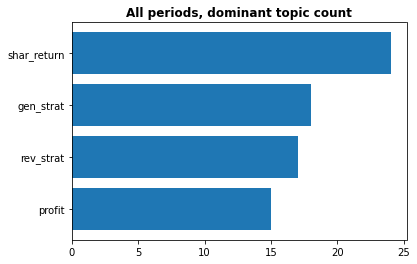

In [403]:
# plot for total period analysis

plt.barh(y=qa_all_res_df.sum()[3:7].sort_values().index.values,
        width=qa_all_res_df.sum()[3:7].sort_values().values)
plt.title('All periods, dominant topic count', fontweight='bold')

In [432]:
latest_mask = (qa_all_res_df.year=='2021') | (qa_all_res_df.year=='2020')
early_mask = (qa_all_res_df.year=='2010') | (qa_all_res_df.year=='2011')

print(qa_all_res_df[latest_mask].sum()[3:7].sort_values())
print(qa_all_res_df[early_mask].sum()[3:7].sort_values())

gen_strat      1
rev_strat      2
profit         3
shar_return    5
dtype: object
shar_return    0
rev_strat      3
profit         3
gen_strat      4
dtype: object


In [ ]:
############################
### LDA on Q&A, unigrams ###
############################

ngrams = (1,1)
num_topics = 3
passes = 100

lda_analysis(train=qa_1011_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1011_df))
lda_analysis(train=qa_1213_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1213_df))
lda_analysis(train=qa_1415_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1415_df))
lda_analysis(train=qa_1617_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1617_df))
lda_analysis(train=qa_1819_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1819_df))
lda_analysis(train=qa_2021_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_2021_df))

In [ ]:
###########################
### LDA on Q&A, bigrams ###
###########################

ngrams = (2,2)
num_topics = 3
passes = 100

lda_analysis(train=qa_1011_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1011_df))
lda_analysis(train=qa_1213_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1213_df))
lda_analysis(train=qa_1415_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1415_df))
lda_analysis(train=qa_1617_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1617_df))
lda_analysis(train=qa_1819_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1819_df))
lda_analysis(train=qa_2021_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_2021_df))


In [ ]:
############################
### LDA on Q&A, trigrams ###
############################

ngrams = (3,3)
num_topics = 3
passes = 100


lda_analysis(train=qa_1011_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1011_df))
lda_analysis(train=qa_1213_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1213_df))
lda_analysis(train=qa_1415_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1415_df))
lda_analysis(train=qa_1617_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1617_df))
lda_analysis(train=qa_1819_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_1819_df))
lda_analysis(train=qa_2021_df, ngrams=ngrams, num_topics=num_topics, passes=passes, corp_name=varname(qa_2021_df))